# Data Processing

In [1]:
path = u"src/data/processed/train.mini.csv"

Reading in word vectors. Reduced to 500k due to RAM limits.

In [2]:
%%time
import gensim
embedding_model = gensim.models.KeyedVectors.load_word2vec_format('src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

CPU times: user 15.3 s, sys: 776 ms, total: 16 s
Wall time: 16.6 s


Create a Dataset for the Amazon reviews.

In [3]:
from torch.utils.data import Dataset
import spacy
import pandas as pd
import numpy as np
import torch

class AmazonReviewDataset(Dataset):
    def __init__(self, path, embedding_model, padding=200, oov="<oov>"):
        
        tokenizer = spacy.load("en_core_web_sm")
        
        self.samples = []
        self.embedding = embedding_model
        
        # Load all the data
        data = pd.read_csv(path)
                
        # Tokenize, pad and vectorize each review
        for index, row in data.iterrows():
            
            # Tokenize
            sentence = [token.lemma_ for token in tokenizer(row["review"])]
            
            # Pad
            sentence = sentence[:padding] + [oov]*(padding - len(sentence))
            
            self.samples.append([row["id"], row["label"], row["alpha"]] + sentence)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        return self.samples[idx]

In [4]:
%%time
dataset = AmazonReviewDataset(path, embedding_model)

CPU times: user 3min 23s, sys: 248 ms, total: 3min 24s
Wall time: 3min 24s


Create a DataLoader as well, using a custom collate function for creating the batches.

In [5]:
import numpy as np
def row2tensors(sentence):
    mean_vec = np.mean([embedding_model[word] for word in sentence[3:] if embedding_model.vocab.get(word) is not None], axis=0).flatten()
    mean_word = embedding_model.similar_by_vector(mean_vec, topn=1)[0][0]
    filled_sentence = [word if embedding_model.vocab.get(word[0]) is not None else (mean_word,) for word in sentence[3:]]
    sentence_as_int = [embedding_model.vocab.get(word[0]).index for word in filled_sentence]
    return sentence_as_int, sentence[1]

In [6]:
def batch2tensor(batch):
    X, Y = [], []
    
    for row in batch:
        x, y = row2tensors(row)
        X.append(x)
        Y.append(y)
        
    return torch.LongTensor(X), torch.LongTensor(Y)

In [7]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=batch2tensor)

Load one example.

In [8]:
dataiter = iter(dataloader)

In [9]:
%%time
X_dash, Y_dash = dataiter.next()

CPU times: user 11.6 ms, sys: 21 µs, total: 11.6 ms
Wall time: 6.11 s


In [10]:
X_dash = X_dash.cuda()
Y_dash = Y_dash.cuda()

In [11]:
X_dash.shape

torch.Size([32, 200])

In [12]:
Y_dash.shape

torch.Size([32])

Definition of the network.

In [13]:
import torch.nn as nn

In [14]:
class Network(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200, category_amount=5):
        super().__init__()
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        

        self.l1 = nn.Linear(embedding_size * padding, 1024)
        self.l2 = nn.Linear(1024, 128)
        self.l3 = nn.Linear(128, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        x = self.l3(x)
        x = self.softmax(x)
        
        return x

In [15]:
model = Network(torch.FloatTensor(embedding_model.vectors)).cuda()

In [16]:
model

Network(
  (embedding): Embedding(500000, 300)
  (l1): Linear(in_features=60000, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [17]:
model(X_dash).shape

torch.Size([32, 5])

In [18]:
model(X_dash)[0].shape

torch.Size([5])

Look at the untrained model.

In [19]:
from matplotlib import pyplot as plt

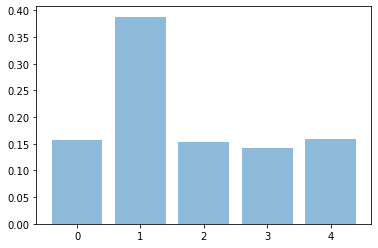

In [20]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

## Training the Model

In [21]:
from torch import optim

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.1, nesterov=False, momentum=0.5)

In [23]:
criterion = nn.NLLLoss()

In [24]:
%%time
epochs = 10
for e in range(epochs):
    running_loss = 0
    for X, Y in dataloader:
        X = X.cuda()
        Y = Y.cuda()
    
        # Reset Gradients
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(dataloader)}")

Training loss: 1.6203687716596804
Training loss: 1.607266703733621
Training loss: 1.5878852346834664
Training loss: 1.5747774035785906
Training loss: 1.5690410323798085
Training loss: 1.5603210324296555
Training loss: 1.5520700726646204
Training loss: 1.5390696205651035
Training loss: 1.5247955885938942
Training loss: 1.5087085448134059


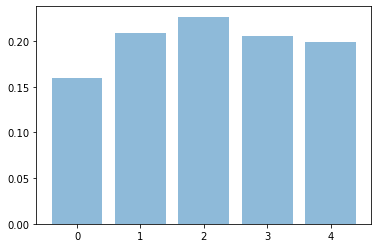

In [27]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [28]:
Y_dash[0]

tensor(3, device='cuda:0')

In [74]:
xt, yt = row2tensors(dataset[4])

In [75]:
XT = torch.LongTensor(xt)

In [76]:
XT = XT.view(1, 200)

In [77]:
XT.shape

torch.Size([1, 200])

In [78]:
model(XT.cuda())

tensor([[-1.5978, -1.1697, -1.3130, -2.0219, -2.4559]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

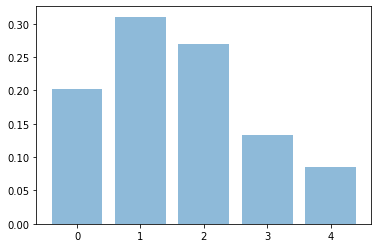

In [79]:
plt.bar(range(0,5), np.exp(model(XT.cuda()).detach().cpu().numpy()[0]), alpha=0.5);

In [80]:
yt

1

# Old

In [ ]:
import pandas as pd 

In [ ]:
train = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/train.csv", header=None)
test = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/test.csv", header=None) 

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
import logging
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

logger = logging.getLogger(__name__)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
input_ids1 = torch.tensor(tokenizer.encode("Hello, my dog is cute".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
input_ids2 = torch.tensor(tokenizer.encode("Hello, my cat is ugly".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1

In [ ]:
input_ids1.shape

In [ ]:
input_ids = torch.cat((input_ids1, input_ids2))

In [ ]:
input_ids.shape

In [ ]:
labels = torch.tensor([0, 1]).unsqueeze(0).to('cuda')   # Batch size 1

In [ ]:
labels

In [ ]:
outputs = model(input_ids, labels=labels)

In [ ]:
outputs

In [ ]:
loss, logits = outputs[:2]

In [ ]:
import numpy as np

In [ ]:
np.exp(logits.detach().cpu().numpy())

In [ ]:
outputs = model(input_ids)

In [ ]:
outputs

## Raw BERT

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [ ]:
tokenizer.tokenize("Hello, my dog is cute")

In [ ]:
tokenizer.cls_token

In [ ]:
tokenizer.convert_tokens_to_ids("[CLS]")

In [ ]:
input_ids

In [ ]:
outputs[1].shape

In [ ]:
outputs[0].shape

In [ ]:
outputs[0][0, 0,:].shape

In [ ]:
a = ("a", "b", "c")

In [ ]:
b = (1, 2) + a

In [ ]:
b

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
!pwd

In [ ]:
model = KeyedVectors.load_word2vec_format('src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model["hello"].shape